# Homework: Basic Artificial Neural Networks

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [2]:
# (re-)load layers
%run homework_modules.ipynb

In [3]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1     

In [4]:
# Iptimizer params
optimizer_config = {'learning_rate' : 0.01, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 50
batch_size = 15000

criterion = MSECriterion()

# Digit classification 

In [5]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['x_train']
        y = data['y_train']
        X_test = data['x_test']
        y_test = data['y_test']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

In [6]:
t = np.array(y).reshape(-1)
Y = np.eye(10)[t]
X = X.reshape([len(X),-1])
t2 = np.array(y_test).reshape(-1)
Y_test = np.eye(10)[t2]
X_test = X_test.reshape([len(X_test),-1])


In [7]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [8]:
def start_train(net, n_epoch):
    loss_history = []
    train_accuracy_history = []
    test_accuracy_history = []
    %run homework_modules.ipynb
    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X, Y), batch_size):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)

            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)

            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      

            loss_history.append(loss)

            #correctCount = 0
            #for i in range(0, predictions.shape[0]):
            #    if(np.allclose(predictions[i],y_batch[i])):
            #        correctCount+=1
            #train_accuracy_history.append(correctCount*100/Y_test.shape[0])


        rnd=np.random.randint(0, X_test.shape[0], batch_size)
        test_prediction=net.forward(X_test[rnd])
        loss_test = criterion.forward(test_prediction,Y_test[rnd])

        correctCount = 0
        for i in range(0, test_prediction.shape[0]):
            if(np.allclose(test_prediction[i],Y_test[rnd][i])):
                correctCount+=1

        test_accuracy_history.append(correctCount*100/test_prediction.shape[0])

        # Visualize
        display.clear_output(wait=True)
        
        plt.subplot(2, 1, 1)
        plt.title("Train loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        plt.show()   

        """plt.subplot(2, 1, 2)
        plt.title("Train accuracy")
        plt.xlabel("#iteration")
        plt.ylabel("accuracy")
        plt.plot(train_accuracy_history, 'b')
        plt.show()  
        """
        plt.subplot(2, 1, 1)
        plt.title("Test accuracy")
        plt.xlabel("#iteration")
        plt.ylabel("accuracy")
        plt.plot(test_accuracy_history, 'b')
        plt.show()   
        
    return test_accuracy_history[-1]
 

# EXPERIMENT 1:

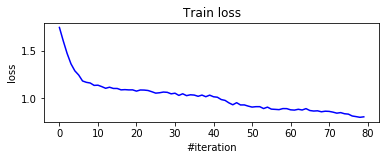

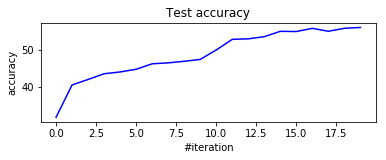

Accuracy: 56.0


In [18]:
net = Sequential()
net.add(Linear(28*28, 10))
net.add(Dropout(0.1))
net.add(SoftMax())
print("Accuracy: " + str(start_train(net, 20)))

# EXPERIMENT 2 (WITHOUT DROPOUT):

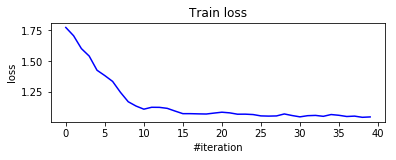

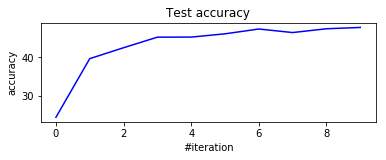

47.85333333333333

In [12]:
net = Sequential()
net.add(Linear(28*28, 10))
net.add(SoftMax())
start_train(net, 10)

# EXPERIMENT 3:

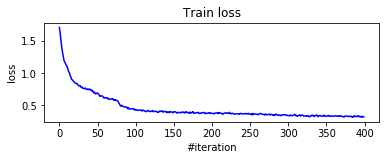

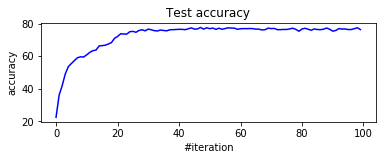

76.3

In [19]:
net = Sequential()
net.add(Linear(28*28, 10))
net.add(Dropout(0.1))
net.add(Linear(10, 10))
net.add(Dropout(0.1))
net.add(SoftMax())

start_train(net, 50)

# EXPERIMENT 4:

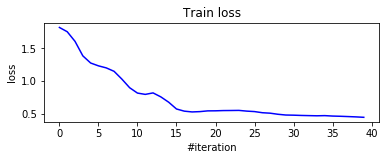

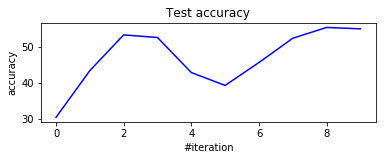

55.1

In [10]:
net = Sequential()
net.add(Linear(28*28, 10))
net.add(Dropout(0.1))
net.add(Linear(10, 10))
net.add(SoftMax())
net.add(Linear(10, 10))
net.add(SoftMax())
start_train(net, 10)

# EXPERIMENT 5:

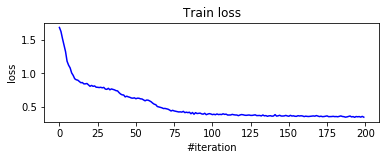

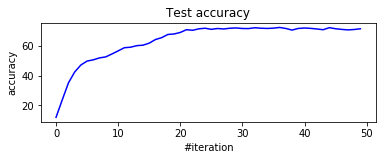

71.58666666666667

In [11]:
net = Sequential()
net.add(Linear(28*28, 10))
net.add(Dropout(0.1))
net.add(ReLU(10, 10))
net.add(Linear(10, 10))
net.add(Dropout(0.05))
net.add(Linear(10, 10))
net.add(SoftMax())
   
start_train(net, 50)